In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [2]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv

--2023-10-13 10:43:26--  http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.119.207, 108.177.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7877383 (7.5M) [text/csv]
Saving to: ‘ecg.csv’

ecg.csv             100%[===================>]   7.51M  11.2MB/s    in 0.7s    

2023-10-13 10:43:27 (11.2 MB/s) - ‘ecg.csv’ saved [7877383/7877383]



In [4]:
!head ecg.csv

-0.11252183,-2.8272038,-3.7738969,-4.3497511,-4.376041,-3.4749863,-2.1814082,-1.8182865,-1.2505219,-0.47749208,-0.36380791,-0.49195659,-0.42185509,-0.30920086,-0.4959387,-0.34211867,-0.35533627,-0.36791303,-0.31650279,-0.41237405,-0.47167181,-0.41345783,-0.36461703,-0.44929829,-0.47141866,-0.42477658,-0.46251673,-0.55247236,-0.47537519,-0.6942,-0.7018681,-0.59381178,-0.66068415,-0.71383066,-0.76980688,-0.67228161,-0.65367605,-0.63940562,-0.55930228,-0.59167032,-0.49322332,-0.46305183,-0.30164382,-0.23273401,-0.12505488,-0.15394314,-0.024357404,-0.065608758,0.034999258,0.061935219,0.07119542,0.12392505,0.10312371,0.22522849,0.12868305,0.30248315,0.25727621,0.19635161,0.17938297,0.24472863,0.34121687,0.32820441,0.40604169,0.44660507,0.42406823,0.48151204,0.4778438,0.62408259,0.57458456,0.59801319,0.5645919,0.607979,0.62063457,0.65625291,0.68474806,0.69427284,0.66558377,0.57579577,0.63813479,0.61491695,0.56908343,0.46857572,0.44281777,0.46827436,0.43249295,0.40795792,0.41862256,0.36253075

In [3]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [51]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [52]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

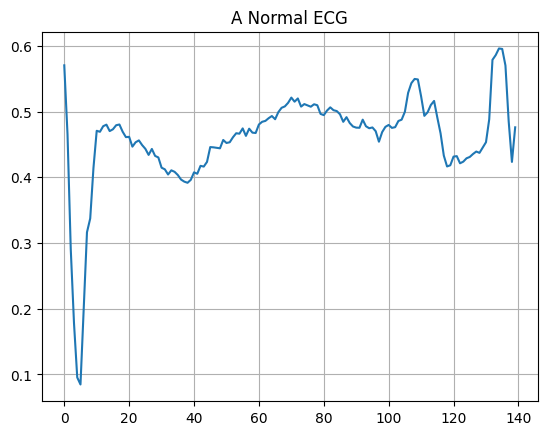

In [8]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

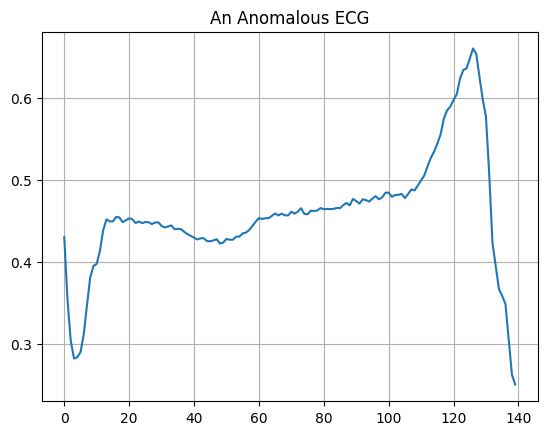

In [9]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [32]:
from tensorflow import keras

In [39]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      keras.Input(shape=(140,1)),
      layers.Conv1D(10, 10, activation="relu"),
      layers.Conv1D(20, 10, activation="relu"),
      layers.Conv1D(30, 10, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(30, 10, activation="relu"),
      layers.Conv1DTranspose(20, 10, activation="relu"),
      layers.Conv1DTranspose(1, 10, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [42]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [54]:
normal_train_data_r = normal_train_data[..., tf.newaxis]
test_data_r = test_data[...,tf.newaxis]

In [55]:
history = autoencoder.fit(normal_train_data_r, normal_train_data_r,
          epochs=20,
          batch_size=512,
          validation_data=(test_data_r, test_data_r),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 11s 975ms/step - loss: 0.0547 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0522 - val_loss: 0.0499
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0513 - val_loss: 0.0497
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0501 - val_loss: 0.0478
Epoch 5/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0484 - val_loss: 0.0459
Epoch 6/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0455 - val_loss: 0.0428
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0418 - val_loss: 0.0452
Epoch 8/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0396 - val_loss: 0.0364
Epoch 9/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0364 - val_loss: 0.0370
Epoch 10/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0341 - val_loss: 0.0336
Epoch 11/20
5/5 [==========

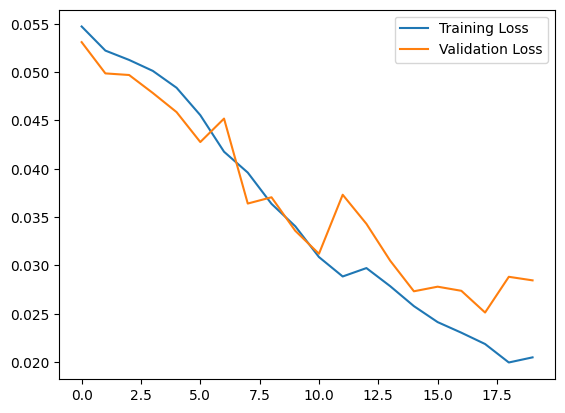

In [56]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

In [58]:
normal_test_data_r = normal_test_data[..., tf.newaxis]

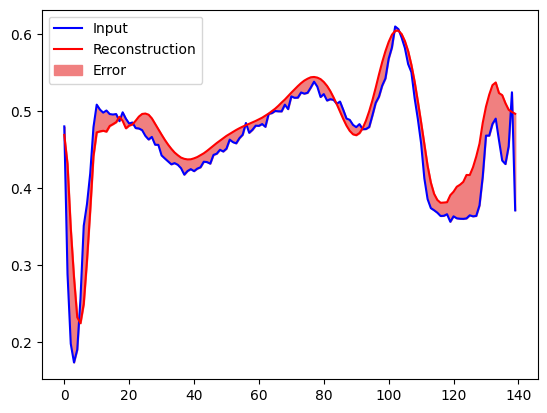

In [60]:
encoded_data = autoencoder.encoder(normal_test_data_r).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), np.squeeze(decoded_data[0]), normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

In [61]:
anomalous_test_data_r = anomalous_test_data[...,tf.newaxis]

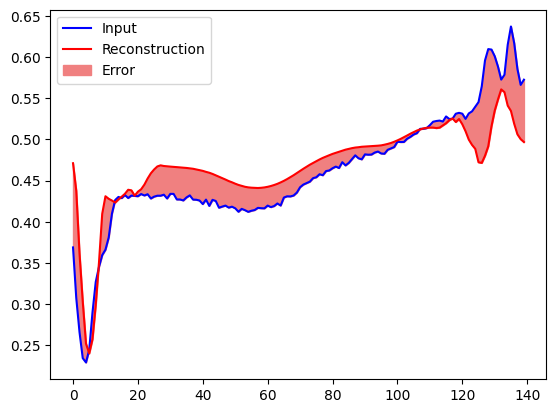

In [62]:
encoded_data = autoencoder.encoder(anomalous_test_data_r).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), np.squeeze(decoded_data[0]), anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

74/74 [==============================] - 0s 3ms/step


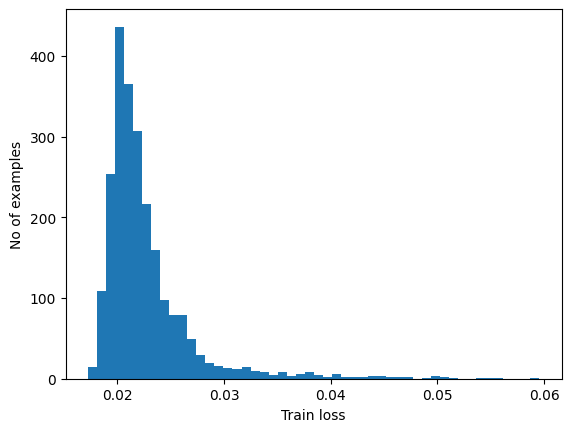

In [65]:
reconstructions = autoencoder.predict(normal_train_data_r)
reconstructions = np.squeeze(reconstructions)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [66]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02711183


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

14/14 [==============================] - 0s 18ms/step


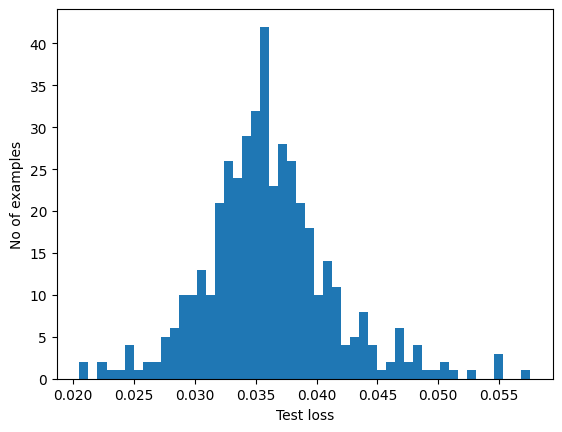

In [68]:
reconstructions = autoencoder.predict(anomalous_test_data_r)
reconstructions = np.squeeze(reconstructions)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [69]:
def predict(model, data, threshold):
  reconstructions = model(data)
  data = np.squeeze(data)
  reconstructions = np.squeeze(reconstructions)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [22]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.941
Precision = 0.9940828402366864
Recall = 0.9


In [72]:
preds = predict(autoencoder, test_data, threshold+0.001)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9615384615384616
Recall = 0.9375


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
